In [1]:
import numpy as np
import matplotlib.pyplot as plt
from prondict import prondict
from lab2_proto import *
from lab2_tools import *
import warnings

In [2]:
warnings.filterwarnings("ignore", category=RuntimeWarning)

data = np.load('lab2_data.npz', allow_pickle=True)['data']
example = np.load('lab2_example.npz', allow_pickle=True)['example'].item()
all_spkr_phone_HMMs = np.load('lab2_models_all.npz', allow_pickle=True)['phoneHMMs'].item()
one_spkr_phone_HMMs = np.load('lab2_models_onespkr.npz', allow_pickle=True)['phoneHMMs'].item()

# Print keys for each .npz file
print("Keys in 'lab2_data.npz':", list(data[1].keys()))
print("Keys in 'lab2_example.npz':", list(example.keys()))
print("Keys in 'lab2_models_all.npz':", list(all_spkr_phone_HMMs.keys()))
print("Keys in 'lab2_models_onespkr.npz':", list(one_spkr_phone_HMMs.keys()))


Keys in 'lab2_data.npz': ['filename', 'samplingrate', 'gender', 'speaker', 'digit', 'repetition', 'samples', 'lmfcc']
Keys in 'lab2_example.npz': ['filename', 'samplingrate', 'gender', 'speaker', 'digit', 'repetition', 'samples', 'lmfcc', 'obsloglik', 'logalpha', 'loglik', 'vloglik', 'vpath', 'logbeta', 'loggamma']
Keys in 'lab2_models_all.npz': ['f', 'k', 'n', 'r', 's', 't', 'v', 'w', 'z', 'ah', 'ao', 'ay', 'eh', 'ey', 'ih', 'iy', 'ow', 'sp', 'th', 'uw', 'sil']
Keys in 'lab2_models_onespkr.npz': ['f', 'k', 'n', 'r', 's', 't', 'v', 'w', 'z', 'ah', 'ao', 'ay', 'eh', 'ey', 'ih', 'iy', 'ow', 'sp', 'th', 'uw', 'sil']


In [3]:
# Concat
isolated = {}
for digit in prondict.keys():
  isolated[digit] = ["sil"] + prondict[digit] + ["sil"]

print(isolated)

all_spkr_word_HMMs, one_spkr_word_HMMs = {}, {}
all_spkr_word_HMMs["o"] = concatHMMs(all_spkr_phone_HMMs, isolated["o"])
one_spkr_word_HMMs["o"] = concatHMMs(all_spkr_phone_HMMs, isolated["o"])

{'o': ['sil', 'ow', 'sil'], 'z': ['sil', 'z', 'iy', 'r', 'ow', 'sil'], '1': ['sil', 'w', 'ah', 'n', 'sil'], '2': ['sil', 't', 'uw', 'sil'], '3': ['sil', 'th', 'r', 'iy', 'sil'], '4': ['sil', 'f', 'ao', 'r', 'sil'], '5': ['sil', 'f', 'ay', 'v', 'sil'], '6': ['sil', 's', 'ih', 'k', 's', 'sil'], '7': ['sil', 's', 'eh', 'v', 'ah', 'n', 'sil'], '8': ['sil', 'ey', 't', 'sil'], '9': ['sil', 'n', 'ay', 'n', 'sil']}


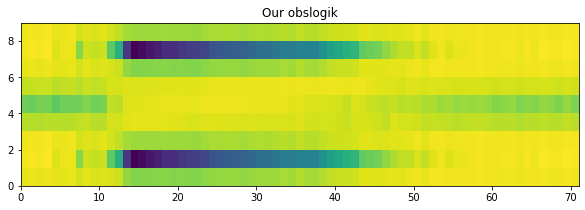

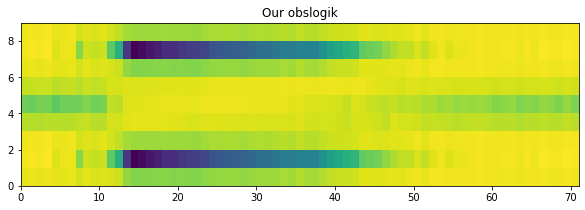

In [4]:
# Gaussian Plot
all_obsloglik = log_multivariate_normal_density_diag(example["lmfcc"], all_spkr_word_HMMs["o"]["means"], all_spkr_word_HMMs["o"]["covars"])
one_obsloglik = log_multivariate_normal_density_diag(example["lmfcc"], one_spkr_word_HMMs["o"]["means"], one_spkr_word_HMMs["o"]["covars"])

fig, ax = plt.subplots(figsize=(10, 3))
ax.pcolormesh(all_obsloglik.T, cmap='viridis')
ax.set_title('Our obslogik')
plt.show()

fig, ax = plt.subplots(figsize=(10, 3))
ax.pcolormesh(one_obsloglik.T, cmap='viridis')
ax.set_title('Our obslogik')
plt.show()

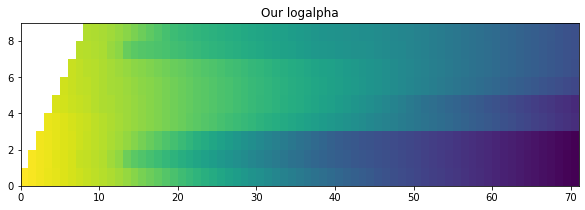

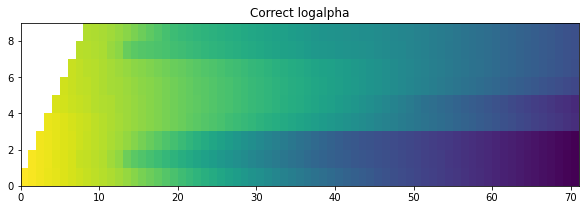

In [5]:
# Forward
logalpha = forward(example["obsloglik"], np.log(one_spkr_word_HMMs["o"]["startprob"]), np.log(one_spkr_word_HMMs["o"]["transmat"]))
fig, ax = plt.subplots(figsize=(10, 3))
ax.pcolormesh(logalpha.T, cmap='viridis')
ax.set_title('Our logalpha')
plt.show()

fig, ax = plt.subplots(figsize=(10, 3))
ax.pcolormesh(example["logalpha"].T, cmap='viridis')
ax.set_title('Correct logalpha')
plt.show()


In [6]:
# Backward
logbeta = backward(one_obsloglik, np.log(one_spkr_word_HMMs['o']['startprob']), np.log(one_spkr_word_HMMs['o']['transmat']))

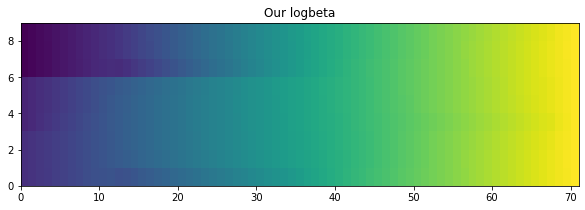

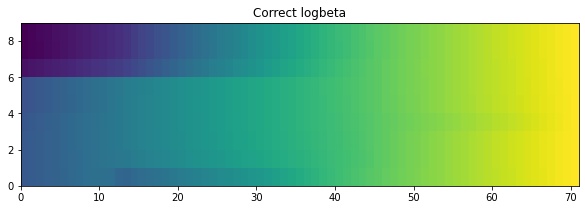

In [7]:
fig, ax = plt.subplots(figsize=(10, 3))
ax.pcolormesh(logbeta.T, cmap='viridis')
ax.set_title('Our logbeta')
plt.show()

fig, ax = plt.subplots(figsize=(10, 3))
ax.pcolormesh(example["logbeta"].T, cmap='viridis')
ax.set_title('Correct logbeta')
plt.show()

In [8]:
# Viterbi
log_gamma = example["loggamma"] #statePosteriors(logalpha, logbeta)

example = np.load('lab2_example.npz', allow_pickle=True)['example'].item()
observed_data = example['lmfcc']

# Update means and covariances based on the observed data and computed state posteriors
means, covars = updateMeanAndVar(observed_data, log_gamma, varianceFloor=5.0)

# Compute emission probabilities if not already computed
log_emlik = log_multivariate_normal_density_diag(observed_data, means, covars)

# Compute Viterbi path and likelihood
viterbi_loglik, viterbi_path = viterbi(log_emlik, np.log(one_spkr_word_HMMs['o']['startprob'][:-1]), np.log(one_spkr_word_HMMs['o']['transmat'][:-1, :-1]), forceFinalState=True)


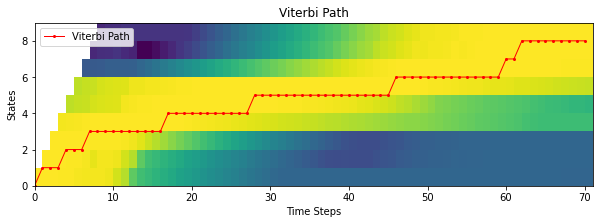

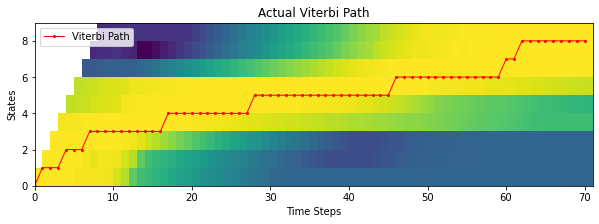

In [9]:
fig, ax = plt.subplots(figsize=(10, 3))
ax.pcolormesh(log_gamma.T, cmap='viridis')
ax.plot(viterbi_path, color='r', marker='o', markersize=2, linestyle='-', linewidth=1, label='Viterbi Path')
ax.set_title("Viterbi Path")
ax.set_xlabel('Time Steps')
ax.set_ylabel('States')
ax.legend()
plt.show()


fig, ax = plt.subplots(figsize=(10, 3))
ax.pcolormesh(example["loggamma"].T, cmap='viridis')
ax.plot(viterbi_path, color='r', marker='o', markersize=2, linestyle='-', linewidth=1, label='Viterbi Path')
ax.set_title("Actual Viterbi Path")
ax.set_xlabel('Time Steps')
ax.set_ylabel('States')
ax.legend()
plt.show()

In [10]:
# Baum-welch
log_gamma = example["loggamma"]#statePosteriors(logalpha, logbeta)

example = np.load('lab2_example.npz', allow_pickle=True)['example'].item()
observed_data = example['lmfcc']

means, covars = baum_welch(observed_data, np.log(one_spkr_word_HMMs['o']['startprob']),
    np.log(one_spkr_word_HMMs['o']['transmat']), means, covars, n_iter=10, varianceFloor=5.0)

# Viterbi

log_emlik = log_multivariate_normal_density_diag(observed_data, means, covars)

# Compute Viterbi path and likelihood
viterbi_loglik, viterbi_path = viterbi(log_emlik, np.log(one_spkr_word_HMMs['o']['startprob'][:-1]), 
    np.log(one_spkr_word_HMMs['o']['transmat'][:-1, :-1]), forceFinalState=True)

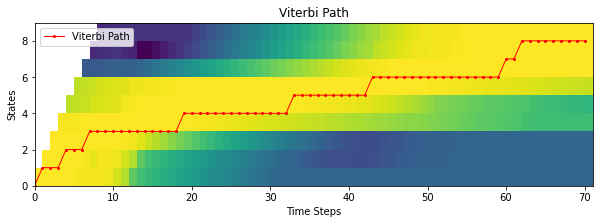

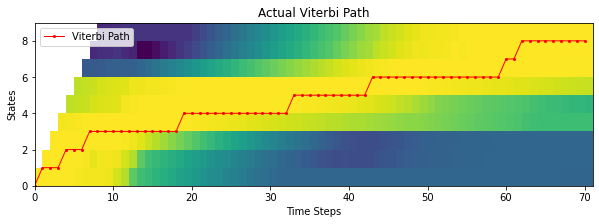

In [11]:
fig, ax = plt.subplots(figsize=(10, 3))
ax.pcolormesh(log_gamma.T, cmap='viridis')
ax.plot(viterbi_path, color='r', marker='o', markersize=2, linestyle='-', linewidth=1, label='Viterbi Path')
ax.set_title("Viterbi Path")
ax.set_xlabel('Time Steps')
ax.set_ylabel('States')
ax.legend()
plt.show()


fig, ax = plt.subplots(figsize=(10, 3))
ax.pcolormesh(example["loggamma"].T, cmap='viridis')
ax.plot(viterbi_path, color='r', marker='o', markersize=2, linestyle='-', linewidth=1, label='Viterbi Path')
ax.set_title("Actual Viterbi Path")
ax.set_xlabel('Time Steps')
ax.set_ylabel('States')
ax.legend()
plt.show()